##### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Machine Bottleneck

This notebook demonstrates the formulation and solution of the a machine bottleneck problem using GLPK/Mathprog. The task is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.

* [MathProg Model](#MathProg-Model)
* [Example](#Example)
* [Visualization](#Visualization)

## MathProg Model

The model uses a 'Big M' implementation of disjunctive constraints to avoid conflicts for a single machine.  Big M should be larger than the longest time horizon for the completion of all jobs. A bound on the longest horizon is the maximum release plus the sum of durations for all jobs.

In [54]:
%%writefile Bottleneck.mod

/* Machine Bottleneck Example */

set JOBS;

param rel{JOBS} default 0;   # Time a job is available to the machine
param dur{JOBS};             # Job duration
param due{JOBS};             # Job due time

/* Data Checks */
check {k in JOBS}: rel[k] + dur[k] <= due[k];

/* The model uses a 'Big M' implementation of disjunctive constraints
to avoid conflicts for a single machine.  Big M should be larger than
the longest time horizon for the completion of all jobs. A bound
on the longest horizon is the maximum release plus the sum of
durations for all jobs. */

param BigM := (max {k in JOBS} rel[k] ) + sum{k in JOBS} dur[k];

/* Decision variables are the start times for each job, and a
disjunctive variable y[j,k] which is 1 if job j precedes job k on
the machine. */

var start{JOBS} >= 0;
var pastdue{JOBS} >= 0;
var y{JOBS,JOBS} binary;

/* There are many possible objectives, including total pastdue, maximum
pastdue (i.e., tardiness), number of jobs pastdue.  */

minimize OBJ : sum {k in JOBS} pastdue[k];

/* Order Constraints */

s.t. START {k in JOBS}: start[k] >= rel[k];
s.t. FINIS {k in JOBS}: start[k] + dur[k] <= due[k] + pastdue[k];

/* Machine Conflict Constraints */

s.t. DA {j in JOBS, k in JOBS : j < k}:
   start[j] + dur[j] <= start[k] + BigM*(1-y[j,k]);
s.t. DB {j in JOBS, k in JOBS : j < k}:
   start[k] + dur[k] <= start[j] + BigM*y[j,k];

solve;

/* Create Tables */

table tout {k in JOBS} OUT "CSV" "Schedule.csv" "table":
    k~Job, rel[k]~Release, start[k]~Start, start[k]+dur[k]~Finish, due[k]~Due;

/* Print Report */

printf " Task     Rel     Dur     Due   Start  Finish Pastdue\n";
printf {k in JOBS} "%5s %7g %7g %7g %7g %7g %7g\n",
   k,rel[k],dur[k],due[k],start[k],start[k]+dur[k],pastdue[k];

end;

Overwriting Bottleneck.mod


## Example

Machine Bottleneck Example from Christelle Gueret, Christian Prins,
Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5,
Dash Optimization, 2000.

In [55]:
%%script glpsol -m Bottleneck.mod -d /dev/stdin -y results.txt --out output

param: JOBS : rel   dur   due :=
         A      2     5    10
         B      5     6    21
         C      4     8    15
         D      0     4    10
         E      0     2     5
         F      8     3    15
         G      9     2    22 ;

end;

In [56]:
print(open('results.txt').read())

 Task     Rel     Dur     Due   Start  Finish Pastdue
    A       2       5      10       6      11       1
    B       5       6      21      14      20       0
    C       4       8      15      22      30      15
    D       0       4      10       2       6       0
    E       0       2       5       0       2       0
    F       8       3      15      11      14       0
    G       9       2      22      20      22       0



In [57]:
import pandas
from IPython.display import display

schedule = pandas.read_csv("Schedule.csv")
display(schedule)

,Job,Release,Start,Finish,Due
0,A,2,6,11,10
1,B,5,14,20,21
2,C,4,22,30,15
3,D,0,2,6,10
4,E,0,0,2,5
5,F,8,11,14,15
6,G,9,20,22,22


## Visualization

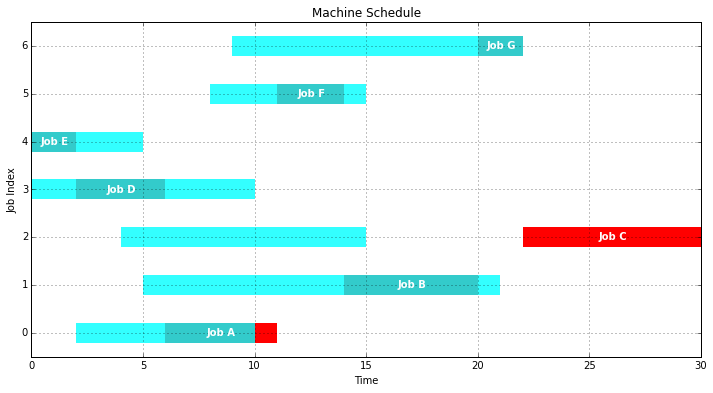

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.hold(True)
for i in schedule.index:
    plt.plot([schedule.ix[i,'Start'],schedule.ix[i,'Finish']],[i,i],
             color='red',alpha=1.0,lw=20,solid_capstyle="butt")
    plt.plot([schedule.ix[i,'Release'],schedule.ix[i,'Due']],[i,i],
             color='cyan',alpha=0.8,lw=20,solid_capstyle="butt")
    plt.text((schedule.ix[i,'Start']+schedule.ix[i,'Finish'])/2.0,i,
             'Job '+schedule.ix[i,'Job'],color='white',weight='bold',
            horizontalalignment='center',verticalalignment='center')

plt.ylim(plt.ylim()[0]-0.5,plt.ylim()[1]+0.5)
plt.title('Machine Schedule')
plt.xlabel('Time')
plt.ylabel('Job Index')
plt.grid()